# 2021 Müller et al scRNA seq analysis OTR vs transduction

Code for the scRNA seq analysis shown in the Paper "Targeted T cell receptor gene editing provides predictable T cell product function for immunotherapy" by Müller et al.

## Initialisation and reading data

In [1]:
import numpy as np                                # scientific computing toolkit
import pandas as pd                               # data analysis toolkit
import scanpy as sc                               # scanpy is referred to with sc.***
import matplotlib.pyplot as plt                   # Matplotlib is referred to with plt.***
from scipy import stats                           # for linear regressions
import seaborn as sns                             # for easy heatmaps
from scipy.sparse import *
import anndata

sc.settings.verbosity = 0                         # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()                       # check if all needed versions are installed and up to date
results_file = './write/results.h5ad'             # the file that will store the analysis results

scanpy==1.4.3 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.1 pandas==1.1.5 scikit-learn==0.21.3 statsmodels==0.11.1 python-igraph==0.7.1+4.bed07760 louvain==0.6.1 leidenalg==0.7.0


In [2]:
sc.settings.set_figure_params(dpi=80, dpi_save=200, color_map='viridis')

In [3]:
adata_1 = sc.read_10x_mtx("./GEX_1_all_TCR/filtered_feature_bc_matrix/",var_names='gene_symbols',cache=True)                                
adata_1.var_names_make_unique()  
adata_1

AnnData object with n_obs × n_vars = 9211 × 33547
    var: 'gene_ids', 'feature_types'

In [4]:
adata_2 = sc.read_10x_mtx("./GEX_2_all_TCR/filtered_feature_bc_matrix/",var_names='gene_symbols',cache=True)                                
adata_2.var_names_make_unique()  
adata_2

AnnData object with n_obs × n_vars = 10101 × 33547
    var: 'gene_ids', 'feature_types'

In [5]:
# combine the two files into an array
adatas = [adata_1,adata_2]
names = ["Sample 1", "Sample 2"]

In [6]:
# generate TRBC_total artificial gene as the sum of TRBC1 and TRBC2 per cell
adatas_new=[0,0]
for i, adata in enumerate(adatas):
    adata.var.loc['TRBC_total']=['TRBC_total', 'Gene Expression']
    TRBC_total_values=[sum(x) for x in zip([x[0] for x in adata[:,adata.var_names=='TRBC1'].X.todense().tolist()], 
                                           [x[0] for x in adata[:,adata.var_names=='TRBC2'].X.todense().tolist()])]
    adatas_new[i]=anndata.AnnData(X=hstack([adata.X,coo_matrix([[x] for x in TRBC_total_values])]).tocsr(), obs=adata.obs, var=adata.var)

In [7]:
adatas=adatas_new.copy()

## Preprocessing

In [8]:
fig, ax = plt.subplots(ncols=len(adatas), figsize=(10,5))
fig.tight_layout(w_pad=3)
for i, adata in enumerate(adatas):
    sc.pl.highest_expr_genes(adata, n_top=15, ax=ax[i], show=False)
    ax[i].set_title(names[i])
fig.savefig('./figures/highest_expr_genes.pdf')

In [9]:
for adata in adatas:
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)

In [10]:
# generate adata with only fluorescent proteins for demultiplexing, filter out triple positive cells and normalize
adatas_FL_1=adata_1[:, adata_1.var_names.isin(['GFP','BFP','CFP-1'])]
adatas_FL_2=adata_2[:, adata_2.var_names.isin(['GFP','BFP','CFP-1'])]
adatas_FL = [adatas_FL_1,adatas_FL_2]
for i, adata_FL in enumerate(adatas_FL):
    sc.pp.filter_cells(adata_FL, max_genes=1)
    sc.pp.normalize_per_cell(adata_FL, counts_per_cell_after=1e4, min_counts=0)
    sc.pp.log1p(adata_FL)
    sc.pp.scale(adata_FL, max_value=10)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [11]:
for adata_FL in adatas_FL: sc.tl.pca(adata_FL)

In [12]:
for adata_FL in adatas_FL:
    sc.pp.neighbors(adata_FL, n_neighbors=20, n_pcs=2)
    sc.tl.umap(adata_FL, spread=65, min_dist=1.9)
    sc.tl.leiden(adata_FL)

C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\umap\umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\umap\umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [13]:
for adata_FL in adatas_FL:
    adata_FL.obs.leiden= adata_FL.obs.leiden.astype(str)
    adata_FL.obs.leiden[~adata_FL.obs.leiden.isin(['0','1','2','3'])]='doublets'
    adata_FL.uns['leiden_colors']=['#078dde','#000000','#ffa55c','#606060','#adadad']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


... storing 'leiden' as categorical
... storing 'feature_types' as categorical


... storing 'leiden' as categorical
... storing 'feature_types' as categorical


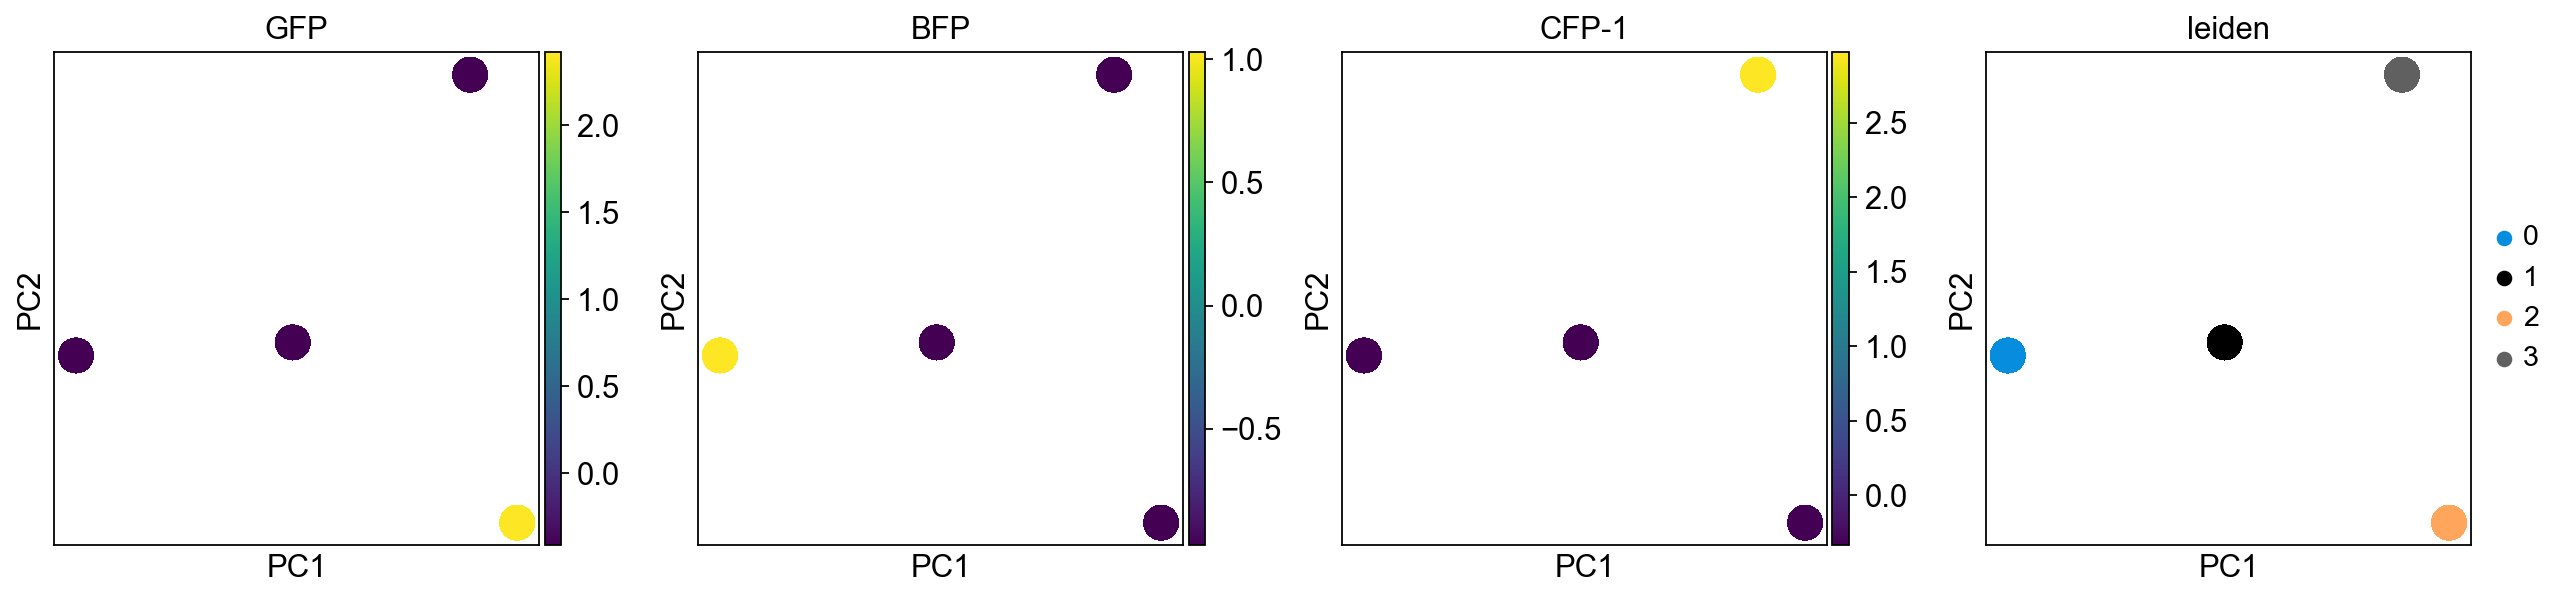

In [14]:
for adata_FL in adatas_FL:
    sc.pl.pca(adata_FL, color=['GFP','BFP','CFP-1','leiden'], s=1000)

In [15]:
for adata_FL in adatas_FL:
    new_cluster_names = ['KI (BFP)','negative', 'low MOI (GFP)','high MOI (CFP)'] # name according to PCA
    adata_FL.rename_categories('leiden', new_cluster_names)
    adata_FL.uns['leiden_colors']=['#078dde','#000000','#ffa55c','#606060','#adadad']

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
fig.tight_layout(w_pad=10)
for i, adata_FL in enumerate(adatas_FL):
    downsampled_adatas=np.zeros(3).tolist()
    for j, fluorophore in enumerate(['KI (BFP)', 'low MOI (GFP)','high MOI (CFP)']):
        downsampled_adatas[j]=sc.pp.subsample(adata_FL[adata_FL.obs.leiden==fluorophore], n_obs=482, copy=True)
    downsampled_adata=downsampled_adatas[0].concatenate(downsampled_adatas[1:])
    sc.pp.neighbors(downsampled_adata, n_neighbors=20, n_pcs=2)
    sc.tl.umap(downsampled_adata, spread=50, min_dist=1.9)
    sc.tl.leiden(downsampled_adata)
    new_cluster_names = ['KI (BFP)', 'low MOI (GFP)','high MOI (CFP)']
    downsampled_adata.rename_categories('leiden', new_cluster_names)
    downsampled_adata.uns['leiden_colors']=['#078dde','#606060','#ffa55c']
    sc.pl.umap(downsampled_adata, color=['leiden'], s=30, ax=ax[i], show=False, title=['TCR 1-4', 'TCR 6-2'][i])
fig.savefig('./figures/final_UMAPs_fluorophores_downsampled.svg', dpi=500)

C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\umap\umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\umap\umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [17]:
for i, adata_FL in enumerate(adatas_FL):
    print(str(adata_FL.obs.leiden.value_counts()[['KI (BFP)','low MOI (GFP)','high MOI (CFP)']].sum())+'/'+str(adata_FL.shape[0])+' cells identified in '+names[i])
    print('\t - '+str(adata_FL.obs.leiden.value_counts()['low MOI (GFP)'])+' for TX low MOI')
    print('\t - '+str(adata_FL.obs.leiden.value_counts()['high MOI (CFP)'])+' for TX high MOI')
    print('\t - '+str(adata_FL.obs.leiden.value_counts()['KI (BFP)'])+' KI')
    print('')

3433/4671 cells identified in Sample 1
	 - 654 for TX low MOI
	 - 575 for TX high MOI
	 - 2204 KI

3477/4739 cells identified in Sample 2
	 - 692 for TX low MOI
	 - 482 for TX high MOI
	 - 2303 KI



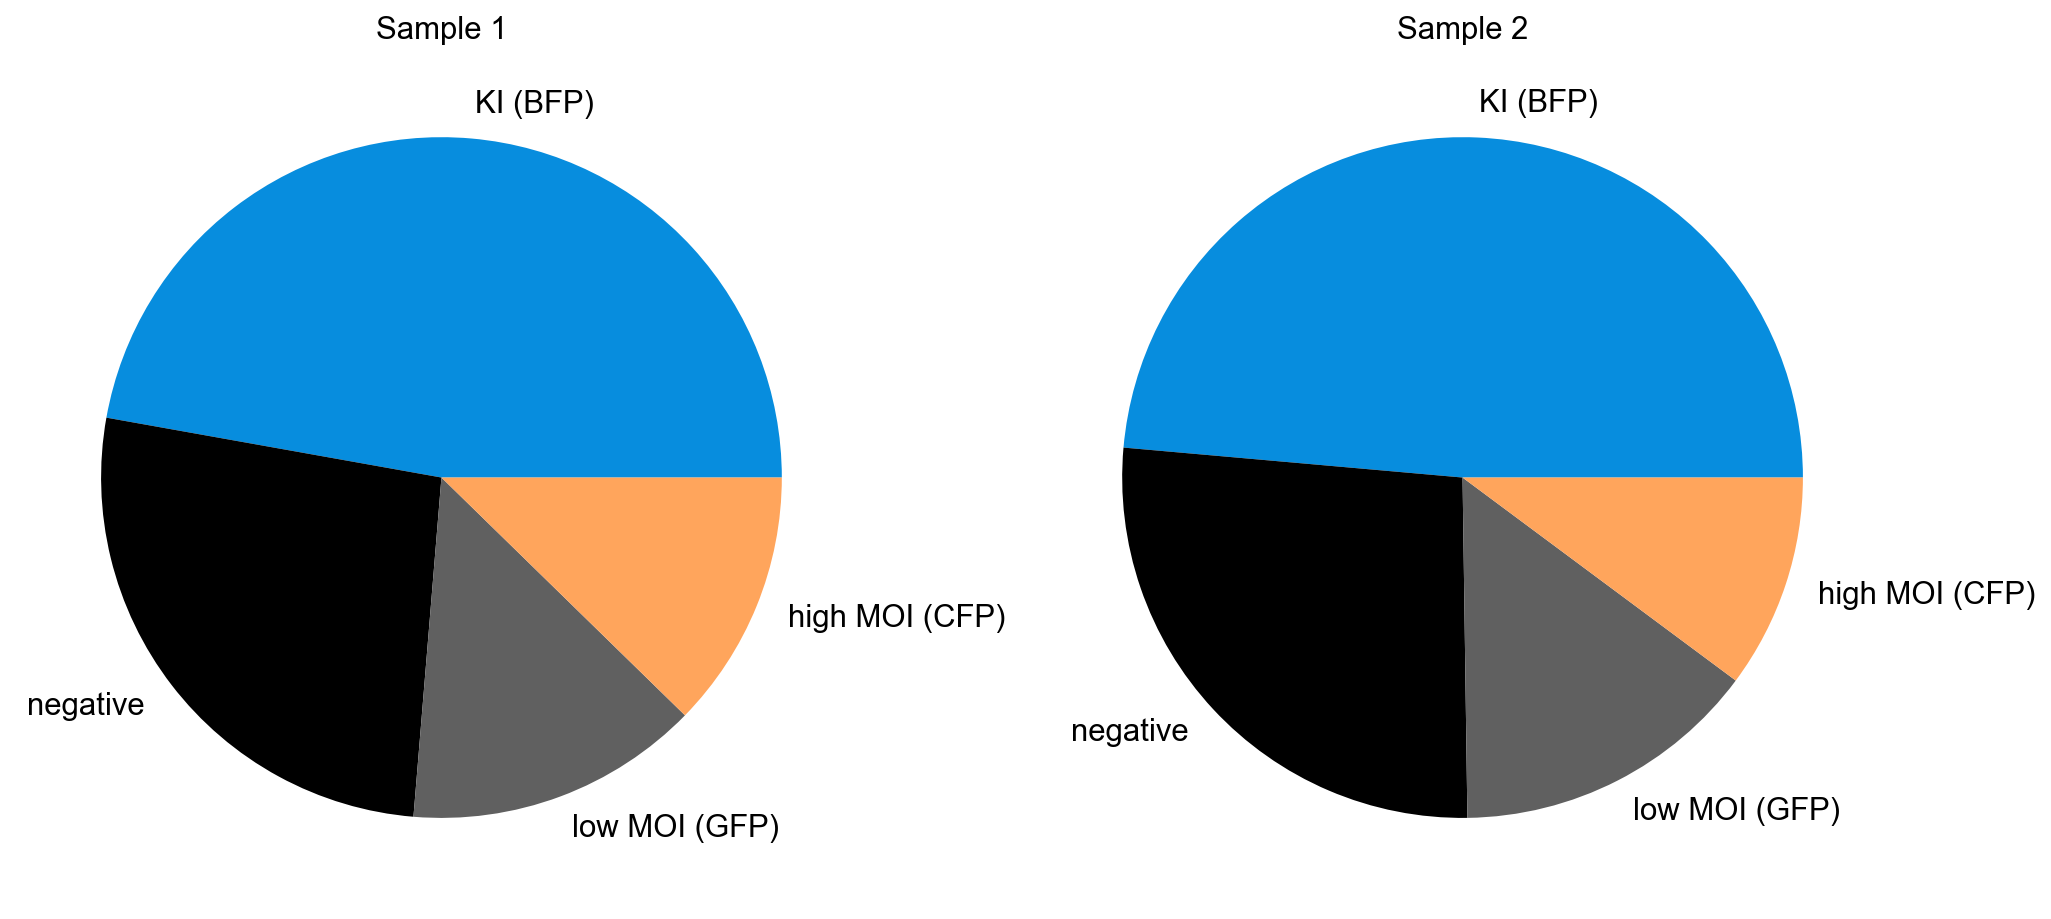

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
for i, adata_FL in enumerate(adatas_FL):
    adata_FL.obs.leiden.value_counts().plot(kind='pie', ax=ax[i], colors=['#078dde','#000000','#606060','#ffa55c'])
    ax[i].set_ylabel('')
    ax[i].set_title(names[i])

In [19]:
# remove fluorescent genes from adata object
adatas_noFL=[0,0]
adatas_noFL[0]=adatas[0][:,~adatas[0].var_names.isin(['GFP','BFP','CFP-1'])].copy()
adatas_noFL[1]=adatas[1][:,~adatas[1].var_names.isin(['GFP','BFP','CFP-1'])].copy()
adatas=[adatas_noFL[0],adatas_noFL[1]]

In [20]:
for adata in adatas:
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [21]:
for adata in adatas:
    ribo_genes = ((adata.var_names.str.startswith("RPL")) | (adata.var_names.str.startswith("RPS"))| (adata.var_names.str.startswith("MPL")))
    adata.obs['percent_ribo'] = np.sum(
    adata[:, ribo_genes].X, axis=1) / np.sum(adata.X, axis=1)
    adata.var['ribo'] = ribo_genes

In [22]:
for adata in adatas:
    sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo'],
             jitter=0.5, multi_panel=True)

... storing 'feature_types' as categorical


... storing 'feature_types' as categorical


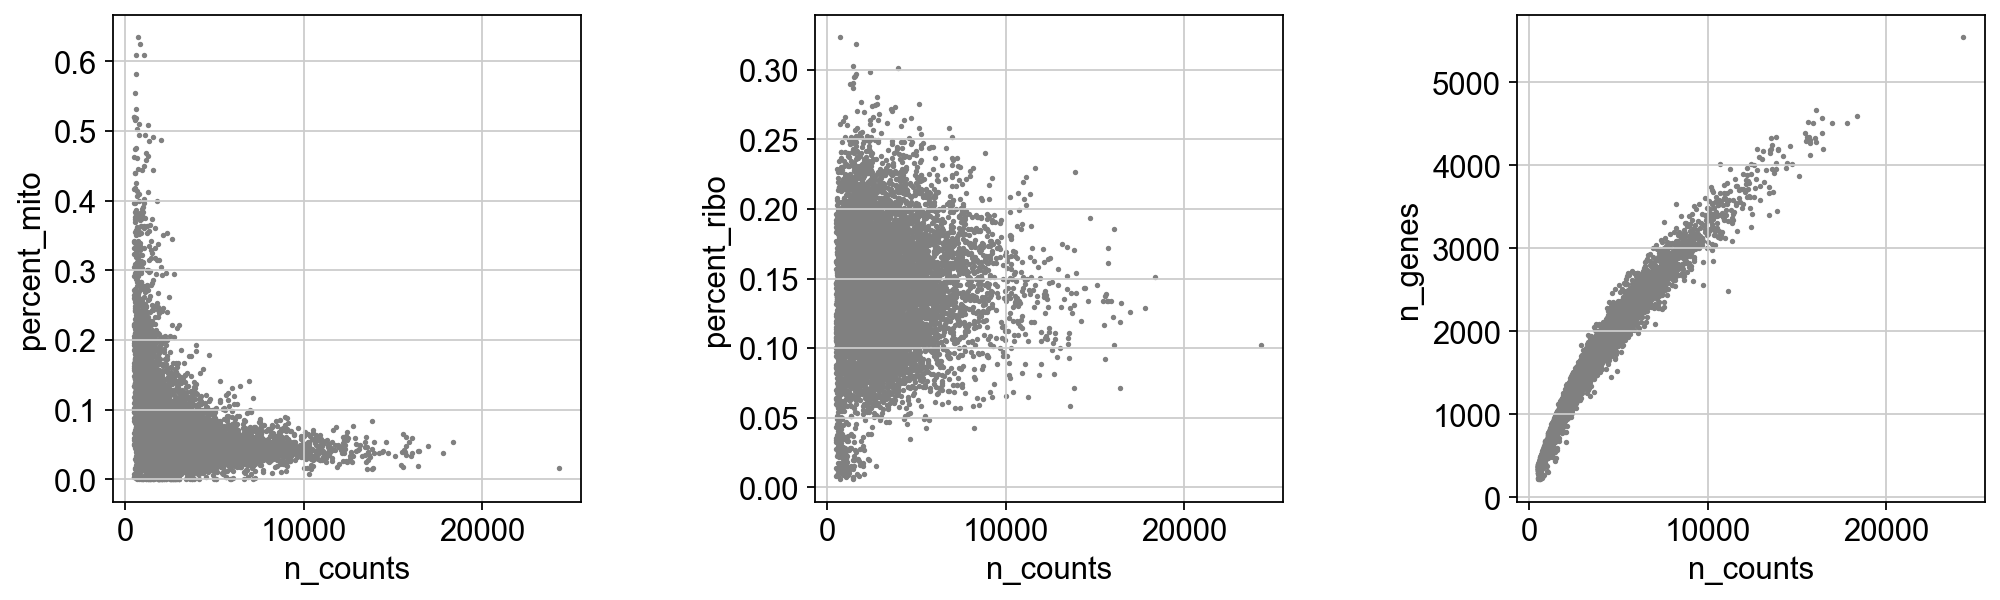

In [23]:
for adata in adatas:
    counts = adata.obs['n_counts']
    mito = adata.obs['percent_mito']
    genes = adata.obs['n_genes']
    ribo = adata.obs['percent_ribo']
    fig = plt.figure(figsize=(15, 4))
    grid = plt.GridSpec(1, 3, hspace=0, wspace=0.5)
    percent_mito = fig.add_subplot(grid[0, 0], xlabel='n_counts', ylabel='percent_mito')
    percent_ribo = fig.add_subplot(grid[0, 1], xlabel='n_counts', ylabel='percent_ribo')
    n_genes = fig.add_subplot(grid[0, 2], xlabel='n_counts', ylabel='n_genes')
    percent_mito.scatter(counts, mito, s=2, c='gray')
    percent_ribo.scatter(counts, ribo, s=2, c='gray')
    n_genes.scatter(counts, genes, s=2, c='gray')

In [24]:
counts_before=[adatas[0].n_obs, adatas[1].n_obs]
adatas[0] = adatas[0][adatas[0].obs['n_genes'] < 4000, :]
adatas[0] = adatas[0][adatas[0].obs['n_counts'] < 15000, :]
adatas[0] = adatas[0][adatas[0].obs['percent_mito'] < 0.2, :]

adatas[1] = adatas[1][adatas[1].obs['n_genes'] < 4000, :]
adatas[1] = adatas[1][adatas[1].obs['n_counts'] < 15000, :]
adatas[1] = adatas[1][adatas[1].obs['percent_mito'] < 0.2, :]

In [25]:
for adata in adatas:
    counts2 = adata.obs['n_counts']
    mito2 = adata.obs['percent_mito']
    genes2 = adata.obs['n_genes']
    ribo2 = adata.obs['percent_ribo']

    fig = plt.figure(figsize=(15, 4))
    grid = plt.GridSpec(1, 3, hspace=0, wspace=0.5)
    percent_mito = fig.add_subplot(grid[0, 0], xlabel='n_counts', ylabel='percent_mito')
    percent_ribo = fig.add_subplot(grid[0, 1], xlabel='n_counts', ylabel='percent_ribo')
    n_genes = fig.add_subplot(grid[0, 2], xlabel='n_counts', ylabel='n_genes')

    percent_mito.scatter(counts, mito, s=3, c='gray')
    percent_ribo.scatter(counts, ribo, s=3, c='gray')
    n_genes.scatter(counts, genes, s=3, c='gray')
    percent_mito.scatter(counts2, mito2, s=2, c='black')
    percent_ribo.scatter(counts2, ribo2, s=2, c='black')
    n_genes.scatter(counts2, genes2, s=2, c='black')

fig.savefig('./figures/filtering.pdf', dpi=2000)

In [26]:
for i, adata in enumerate(adatas):
    print(names[i]+': '+str(counts_before[i])+' --> '+str(adata.n_obs))

Sample 1: 9178 --> 8203
Sample 2: 10040 --> 9560


## Annotation of Subsamples

In [27]:
adatas[0].obs["subsample"]='not specified'
adatas[1].obs["subsample"]='not specified'

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [28]:
adatas[0].obs.subsample[adatas[0].obs_names.isin(adatas_FL[0][adatas_FL[0].obs.leiden=='KI (BFP)'].obs_names)]='KI (BFP)'
adatas[0].obs.subsample[adatas[0].obs_names.isin(adatas_FL[0][adatas_FL[0].obs.leiden=='low MOI (GFP)'].obs_names)]='low MOI (GFP)'
adatas[0].obs.subsample[adatas[0].obs_names.isin(adatas_FL[0][adatas_FL[0].obs.leiden=='high MOI (CFP)'].obs_names)]='high MOI (CFP)'

adatas[1].obs.subsample[adatas[1].obs_names.isin(adatas_FL[1][adatas_FL[1].obs.leiden=='KI (BFP)'].obs_names)]='KI (BFP)'
adatas[1].obs.subsample[adatas[1].obs_names.isin(adatas_FL[1][adatas_FL[1].obs.leiden=='low MOI (GFP)'].obs_names)]='low MOI (GFP)'
adatas[1].obs.subsample[adatas[1].obs_names.isin(adatas_FL[1][adatas_FL[1].obs.leiden=='high MOI (CFP)'].obs_names)]='high MOI (CFP)'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so w

In [29]:
adatas_sub=[0,0]
adatas_sub[0]=adatas[0][adatas[0].obs.subsample!='not specified'].copy()
adatas_sub[1]=adatas[1][adatas[1].obs.subsample!='not specified'].copy()
adatas=[adatas_sub[0],adatas_sub[1]]

In [30]:
# Remove background in the specific groups (TX: - HDR construct=0, KI: TX- construct=0)
for adata in adatas:
    adata[adata.obs.subsample=='low MOI (GFP)',adata.var_names.isin(['HDR_KI_TCR1-4', 'HDR_KI_TCR6-2'])].X=0
    adata[adata.obs.subsample=='high MOI (CFP)',adata.var_names.isin(['HDR_KI_TCR1-4', 'HDR_KI_TCR6-2'])].X=0
    adata[adata.obs.subsample=='KI (BFP)',adata.var_names.isin(['TX_TCR1-4', 'TX_TCR6-2'])].X=0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell, so that counts become comparable among cells.

In [31]:
for adata in adatas:
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)

## Cell cycle scoring

In [32]:
cc_genes=pd.read_csv("./analysis_info/regev_lab_cell_cycle_genes.txt")
s_genes=cc_genes[:46]
g2m_genes=cc_genes[47:]
s_genes.columns=['genes']
g2m_genes.columns=['genes']
for adata in adatas:
    sc.tl.score_genes_cell_cycle(adata, s_genes.genes, g2m_genes.genes)

... storing 'subsample' as categorical
... storing 'phase' as categorical
... storing 'subsample' as categorical
... storing 'phase' as categorical


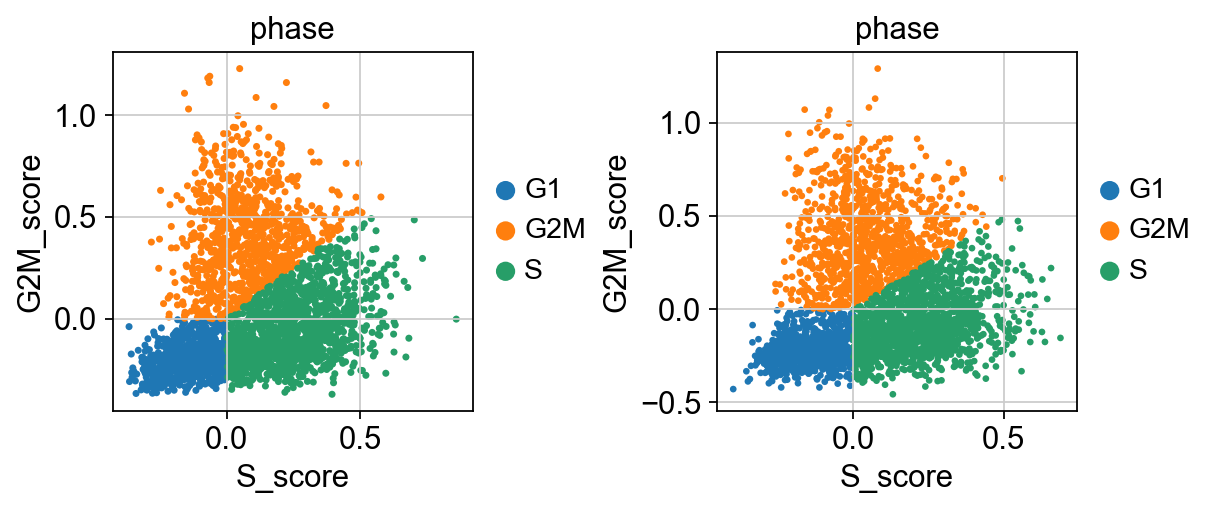

In [33]:
fig, ax = plt.subplots(ncols=len(adatas), figsize=(7,3))
fig.tight_layout(w_pad=5)
for i, adata in enumerate(adatas):
    sc.pl.scatter(adata, x='S_score', y='G2M_score', color='phase', ax=ax[i], show=False)

Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object. While many people consider the normalized data matrix as the "relevant data" for visualization and differential testing, some would prefer to store the unnormalized data.

In [34]:
adata=adatas[0].concatenate(adatas[1])
adata.raw=adata

In [35]:
adata.uns['subsample_colors']=['#078dde','#606060','#ffa55c']

Identify highly-variable genes.

In [36]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [37]:
adata = adata[:, np.logical_or(adata.var_names.isin(['MALAT1','ACTB','B2M', 'GAPDH', 'VIM', 'HDR_KI_TCR1-4', 'HDR_KI_TCR6-2', 'TX_TCR1-4', 'TX_TCR6-2','TRBC1','TRBC2','TRBC_total','TRBC_endo','TRAC_endo']),adata.var['highly_variable'])]
sc.pp.regress_out(adata, ['n_counts', 'percent_mito', 'S_score', 'G2M_score'])
sc.pp.scale(adata, max_value=10)

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [38]:
# Remove constructs for the clustering analysis 
adata_for_pca=adata[:,~adata.var_names.isin(['HDR_KI_TCR1-4', 'HDR_KI_TCR6-2', 'TX_TCR1-4', 'TX_TCR6-2','TRBC_total'])]

In [39]:
sc.tl.pca(adata_for_pca, svd_solver='arpack')

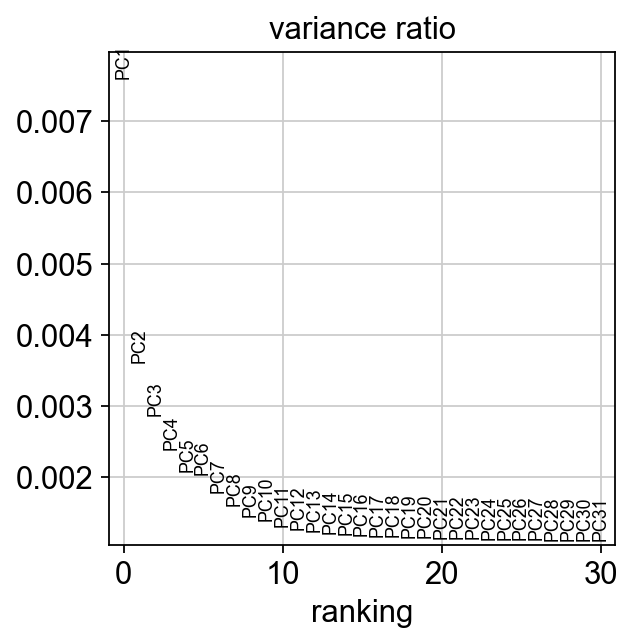

In [40]:
sc.pl.pca_variance_ratio(adata_for_pca)

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [41]:
sc.pp.neighbors(adata_for_pca, n_neighbors=10, n_pcs=7)

## Embedding the neighborhood graph

In [42]:
sc.tl.umap(adata_for_pca)

In [43]:
# Move back to all genes including the constructs
adata.uns=adata_for_pca.uns
adata.obsm=adata_for_pca.obsm
adata.obsp=adata_for_pca.obsp

In [44]:
titles=['TCR 1-4', 'TCR 6-2']
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
fig.tight_layout(w_pad=10)
for i, batch in enumerate(adata.obs.batch.unique()):
    downsampled_adatas=np.zeros(3).tolist()
    for j, subsample in enumerate(adata.obs.subsample.unique()):
        downsampled_adatas[j]=sc.pp.subsample(adata[np.logical_and(adata.obs.batch==batch,adata.obs.subsample==subsample)], n_obs=450, copy=True)
    downsampled_adata=downsampled_adatas[0].concatenate(downsampled_adatas[1:])
    downsampled_adata.uns['subsample_colors']=['#078dde','#ffa55c','#606060']
    sc.pl.umap(downsampled_adata, color='subsample', title=titles[i], ax=ax[i], show=False)
fig.savefig('./figures/final_UMAPs_editing_method_per_TCR.svg', dpi=500)

... storing 'subsample' as categorical
... storing 'subsample' as categorical


In [45]:
titles=['TX low', 'TX high', 'KI']
fig, ax = plt.subplots(ncols=3, figsize=(14,4))
fig.tight_layout(w_pad=5)
for i, subsample in enumerate(adata.obs.subsample.unique()):
    downsampled_adatas=np.zeros(2).tolist()
    for j, batch in enumerate(adata.obs.batch.unique()):
        downsampled_adatas[j]=sc.pp.subsample(adata[np.logical_and(adata.obs.batch==batch,adata.obs.subsample==subsample)], n_obs=450, copy=True)
    downsampled_adata=downsampled_adatas[0].concatenate(downsampled_adatas[1:])
    downsampled_adata.uns['batch_colors']=['#000000','#ffffff']
    downsampled_adata.rename_categories('batch', ['TCR 1-4', 'TCR 6-2'])
    sc.pl.umap(downsampled_adata, color='batch', title=titles[i], ax=ax[i], show=False, linewidths=0.6, edgecolor='black')
fig.savefig('./figures/final_UMAPs_TCR_per_editing_method_weiss.svg', dpi=500)

## Clustering the neighborhood graph

In [46]:
from sklearn.metrics import silhouette_score
def titrate_leiden_resolution(adata):
    res_array=list(np.round(np.linspace(.1, 2, 20),1))
    silhoutte_list=list()
    sc.settings.verbosity = 1
    for i,res in enumerate(res_array):
        sc.tl.leiden(adata, resolution=res)
        if adata.obs.leiden.unique().shape[0]>2:
            silhoutte_list.append(silhouette_score(adata.obsm['X_umap'],
                    adata.obs[f'leiden'],
                    metric='euclidean'))
        else:
            silhoutte_list.append(np.nan)
        print(str(np.round(((i+1)/len(res_array))*100,1))+"%", end="\r", flush=True)
    sns.lineplot(res_array, silhoutte_list, color='black', marker='o')
    print(silhoutte_list)

[nan, nan, 0.10384194, 0.16971079, 0.08649233, 0.04930613, 0.02317551, -0.010473365, -0.016712414, 0.017659063, -0.0498321, -0.07392946, -0.012762512, -0.053683866, -0.051172193, -0.045233022, -0.06321185, -0.065943345, -0.07732258, -0.09851311]


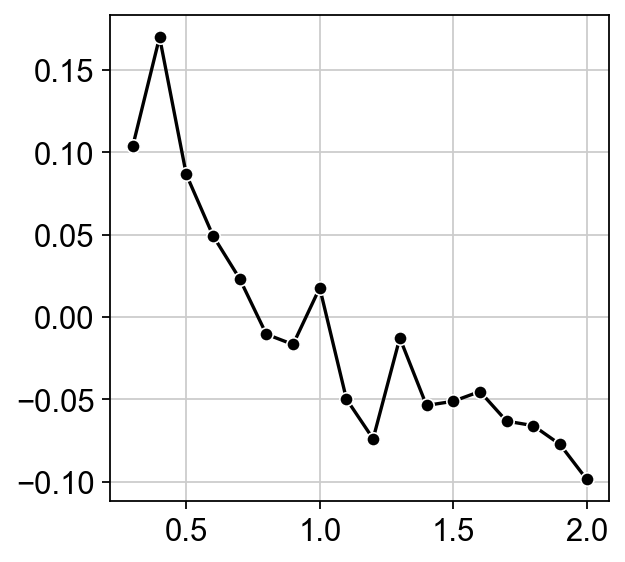

In [47]:
titrate_leiden_resolution(adata)

In [48]:
sc.tl.leiden(adata, resolution=1)
print(silhouette_score(adata.obsm['X_umap'],adata.obs[f'leiden'],metric='euclidean'))

0.017659063


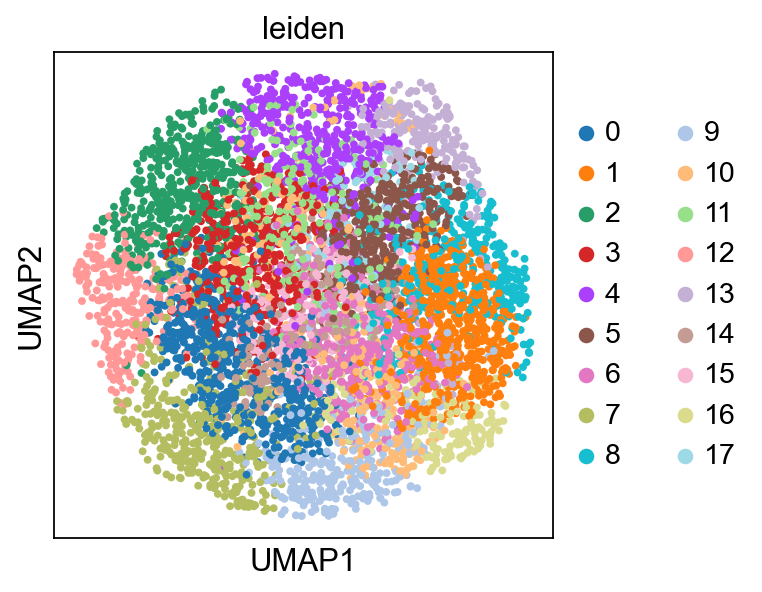

In [49]:
sc.pl.umap(adata, color=['leiden'], save='_leiden.pdf', s=50)

In [53]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'pvals']}).to_csv('marker_genes.csv')

# Analyze TX and KI reads

In [54]:
#filter BG according to the fluorescent protein subsamples
adata.X[adata.obs.subsample=='GFP',-4:-2]=0
adata.X[adata.obs.subsample=='CFP',-4:-2]=0
adata.X[adata.obs.subsample=='BFP',-2:]=0

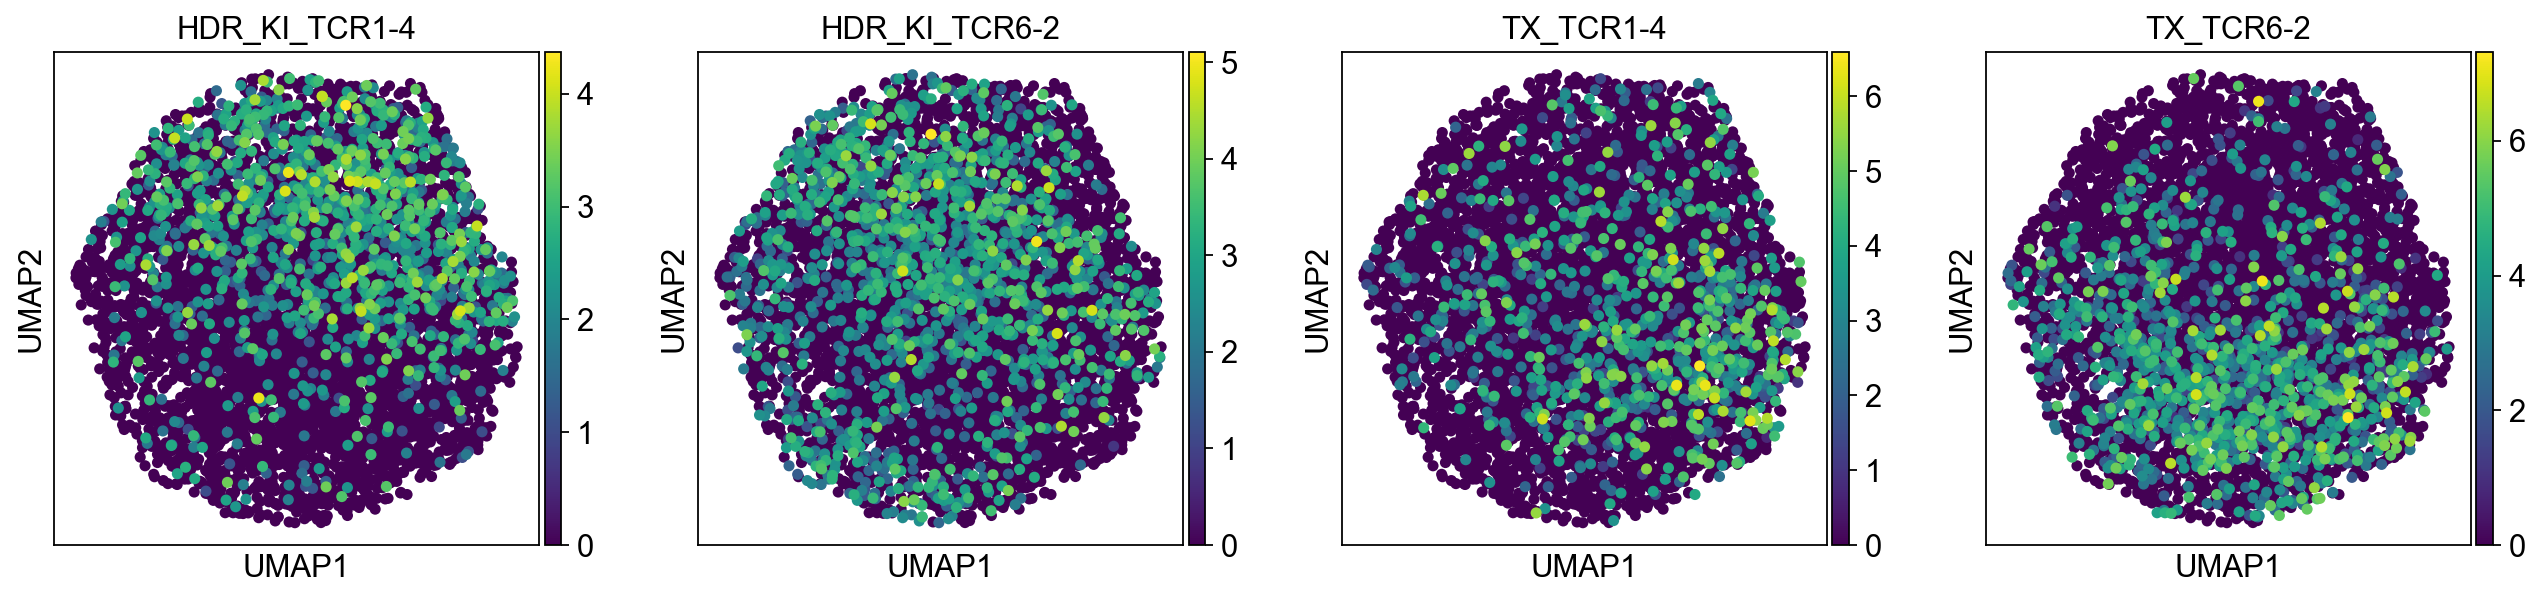

In [55]:
#sc.pl.umap(adata, color=['leiden','CFP-1', 'GFP', 'BFP'], s=100)
sc.pl.umap(adata, color=['HDR_KI_TCR1-4', 'HDR_KI_TCR6-2', 'TX_TCR1-4', 'TX_TCR6-2'], s=100, use_raw=True)

In [56]:
selected_genes=['MALAT1','ACTB','B2M', 'GAPDH', 'VIM', 'HDR_KI_TCR1-4', 'HDR_KI_TCR6-2', 'TX_TCR1-4', 'TX_TCR6-2','TRAC','TRBC1','TRBC2','TRBC_total']
selecte_genes_raw_index=[adata.raw.var_names.tolist().index(x) for x in selected_genes]
for batch in adata.obs.batch.unique(): 
    for subsample in adata.obs.subsample.unique():
        selected_cells = adata[np.logical_and(adata.obs.batch==batch,adata.obs.subsample==subsample)].obs_names
        selected_cells_index = [adata.obs_names.tolist().index(x) for x in selected_cells]
        pd.DataFrame(adata.raw.X.todense()[:,selecte_genes_raw_index], columns=selected_genes).iloc[selected_cells_index].to_csv(batch+'_'+subsample+'.csv')

In [57]:
selected_genes=['HDR_KI_TCR1-4', 'HDR_KI_TCR6-2', 'TX_TCR1-4', 'TX_TCR6-2']+adata.var_names[adata.var_names.str.contains('TRAV')].tolist()
selecte_genes_raw_index=[adata.raw.var_names.tolist().index(x) for x in selected_genes]
for batch in adata.obs.batch.unique(): 
    for subsample in adata.obs.subsample.unique():
        selected_cells = adata[np.logical_and(adata.obs.batch==batch,adata.obs.subsample==subsample)].obs_names
        selected_cells_index = [adata.obs_names.tolist().index(x) for x in selected_cells]
        pd.DataFrame(adata.raw.X.todense()[:,selecte_genes_raw_index], columns=selected_genes).iloc[selected_cells_index].to_csv(batch+'_'+subsample+'_TRAV.csv')